In [3]:
# From: https://www.kaggle.com/c/dog-breed-identification/data
# Author: Morpheus Hsieh (morpheus.hsieh@gmail.com)

from __future__ import print_function, division

import os, sys
import copy
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime
from os import listdir
from os.path import join, exists, isfile
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1


In [4]:
Params = {
    'DataPath'    : r'D:\GitWork\dog_breed\data',
    'OutPath'     : r'D:\GitWork\dog_breed\output',
    'ProcPath'    : r'D:\GitWork\dog_breed\processed',
    'PreTrainPath': r'D:\GitWork\dog_breed\pretrained',
    'PreTrainFile': '',
    'TestPath'    : r'D:\Dataset\dog-breed-identification\test',
    'TrainPath'   : r'D:\Dataset\dog-breed-identification\train',
    'CsvLabel'    : 'labels.csv',
    'BatchSize'   : 16,
    'FracForTrain': 0.8
}


def prettyDict(dic, indent=2):
    array = []
    key_maxlen = 0
    item_cnt = 0
    item_size = len(dic)
    split_str = ': '
    
    for key, val in dic.items():
        if key_maxlen < len(str(key)): 
            key_maxlen = len(str(key))
        
        tmpstr = ''
        tmpstr += f"'{key}'" if isinstance(key, str) else f"{key}"
        tmpstr += split_str
        tmpstr += f"'{val}'" if isinstance(val, str) else f"{val}"

        item_cnt += 1
        if item_cnt < item_size: tmpstr += ','
        array.append(tmpstr)
    
    for i in range(len(array)):
        inStr = array[i]
        ary = inStr.split(split_str)
        key = ary[0].ljust(key_maxlen+2)
        val = ary[1]
        array[i] = (' '*indent) + key + ': ' + val
        
    outstr = '{\n' + '\n'.join(array) + '\n}'
    return outstr

outstr = prettyDict(Params)
print('Parameters:')
print(outstr)

Parameters:
{
  'DataPath'    : 'D:\GitWork\dog_breed\data',
  'OutPath'     : 'D:\GitWork\dog_breed\output',
  'ProcPath'    : 'D:\GitWork\dog_breed\processed',
  'PreTrainPath': 'D:\GitWork\dog_breed\pretrained',
  'PreTrainFile': '',
  'TestPath'    : 'D:\Dataset\dog-breed-identification\test',
  'TrainPath'   : 'D:\Dataset\dog-breed-identification\train',
  'CsvLabel'    : 'labels.csv',
  'BatchSize'   : 16,
  'FracForTrain': 0.8
}


In [5]:
# Read breed information from csv
DataPath = Params.get('DataPath')
csv_labels = Params.get('CsvLabel')
f_abspath = join(DataPath, csv_labels)

df_labels = pd.read_csv(f_abspath)

print(df_labels.info())
print()
print(df_labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
from IPython.display import display
display(df_labels.head(10))

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [4]:
# Count all breeds
def countBreeds(df):
    df1 = df_labels.groupby("breed")["id"].count().reset_index(name="count")
    df1 = df1.sort_values(by='count', ascending=False).reset_index(drop=True)
    df1.insert(0, 'breed_id', df1.index)
    return df1

df_breeds = countBreeds(df_labels)
print(df_breeds.info())
print()
print(df_breeds.head())

NumClasses = int(df_breeds.shape[0])
print('\nNum classes:', NumClasses)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   breed_id  120 non-null    int64 
 1   breed     120 non-null    object
 2   count     120 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ KB
None

   breed_id                 breed  count
0         0    scottish_deerhound    126
1         1           maltese_dog    117
2         2          afghan_hound    116
3         3           entlebucher    115
4         4  bernese_mountain_dog    114

Num classes: 120


In [5]:
# Process labels

dict_bid_fw = dict(df_breeds[['breed', 'breed_id']].values)
# print(dict_bid_fw)

dict_bid_bw = dict(df_breeds[['breed_id', 'breed']].values)
# print(dict_bid_bw)

# Build processed labels file
df_data = pd.DataFrame(columns=['image', 'breed_id'])
df_data['breed_id'] = df_labels.breed.map(dict_bid_fw)

TranPath = Params['TrainPath']

df_data['image'] = df_labels.apply (
    lambda row: join(TranPath, row['id']+'.jpg') \
    if exists(join(TranPath, row['id']+'.jpg')) else None, 
    axis=1
)

print(df_data.info())
print(df_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     10222 non-null  object
 1   breed_id  10222 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.8+ KB
None
                                               image  breed_id
0  D:\Dataset\dog-breed-identification\train\000b...        42
1  D:\Dataset\dog-breed-identification\train\0015...        72
2  D:\Dataset\dog-breed-identification\train\001c...        94
3  D:\Dataset\dog-breed-identification\train\0021...        50
4  D:\Dataset\dog-breed-identification\train\0021...       115


In [6]:
# Create dataset

# Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225]
    )
])

class myDataset(Dataset):

    def __init__(self, df, phase='train', frac=0.8, transform=None):
        
        num_rows = df.shape[0]
        train_len = int(float(frac) * float(num_rows))
        valid_len = num_rows - train_len
        
        # data = df.head(train_len) if phase=='train' else df.tail(valid_len)
        
        # get random image id without duplicates
        idx_ary = np.arange(len(df))
        idx_ary_rand = np.random.permutation(idx_ary) # random shuffle
        
        data_len = train_len if phase=='train' else valid_len
        data = df.loc[idx_ary_rand[:data_len]]
        
        self.images = data['image'].tolist()
        self.labels = data['breed_id'].tolist()

        self.transform = transform
        self.len = len(self.images)

    def __getitem__(self, index):
        f_abspath = self.images[index]
        img_pil = Image.open(f_abspath)

        if self.transform is not None:
            img = self.transform(img_pil)

        lbl = int(self.labels[index])
        iid = os.path.split(f_abspath)[1].replace('.jpg', '')
        
        return [img, lbl, iid]

    def __len__(self):
        return self.len
    

frac = Params['FracForTrain']

phases = ['train', 'valid']
dataSet = { 
    x: myDataset(df_data, phase=x, frac=frac, transform=transform) for x in phases 
}

BatchSize = Params['BatchSize']
dataLoader = {
    x: DataLoader(dataSet[x], batch_size=BatchSize, shuffle=True) for x in phases
}

dataSizes = { x: len(dataSet[x]) for x in phases }
print('DataSet size:', dataSizes)

trainLoader = dataLoader['train']
imgs, lbls, iids = next(iter(trainLoader))
print('\nImage shape:', imgs.size())
print('Label shape:', lbls.size())

print('\nImage iid:')
id_list = [''.join(iid) for iid in iids]
print('  '+'\n  '.join(id_list))

img = imgs[0]
print('\nImage shape:', img.shape)
print(); print(img)

print('\nLabels:', lbls[0])

DataSet size: {'train': 8177, 'valid': 2045}

Image shape: torch.Size([16, 3, 224, 224])
Label shape: torch.Size([16])

Image iid:
  896ae4eda6310c5fa223131ac7574494
  adc5daa413e246287aacf9b7f6e16d36
  9c8bab83db2da5aad21f41e44643de64
  5f11e117f4ba6ed026682fe516651c59
  dd52583a6a9bfdcc5278c5d61a57b7e1
  c9be1b14a664fab3d09d0ca4b8a79cbf
  8befc822b56b744d72872428a0ef4851
  278739637271fe972aa9a62404685a24
  e4b586f1a120bba42545d866d45d0602
  dfc97c3d7a59ad4d89e791e6ab14c49f
  78e7aa41b7f4326a7f582426a3fdb151
  c3487bbf17be7def166026f875edbdc0
  bbb3573b1f9a2f3ab1b1d62cc26a7b88
  c2a5c44a3cb6d8e5fc36ff0bb8640776
  d5b01922a98bd60cd867e7b6d62039f2
  5df814fe3a8b8b678baf9afe62998291

Image shape: torch.Size([3, 224, 224])

tensor([[[-0.2513, -0.1657, -0.6452,  ..., -1.5528, -1.2959, -0.5424],
         [-0.9877, -0.6794, -0.5082,  ..., -1.2274, -0.8335, -0.2171],
         [-1.0733, -1.4500, -0.4911,  ..., -0.8849, -0.4226, -0.0801],
         ...,
         [ 0.8104,  0.5707,  0.7248,  ...

In [7]:
# Use GPU for train
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

cuda:0


In [8]:
# Build Model
def buildModel(use_gpu, numClasses, preTrainModel=None):
    model = models.resnet50(pretrained=True)
    # model = torchvision.models.resnet50()

    # freeze all model parameters
    for param in model.parameters():
        model.requires_grad = False

    # new final layer with 16 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, numClasses)
    
    if preTrainModel is not None:
        model.load_state_dict(preTrainModel)
        
    if use_gpu: 
        model = model.cuda()
        
    return model


TrainPath = Params['PreTrainPath']
TrainFile = Params['PreTrainFile']
f_pretrain = join(TrainPath, TrainFile)

pretrain_model = None
if exists(f_pretrain) and isfile(f_pretrain):
    pretrain_model = torch.load(join(path, fname))

model = buildModel(use_gpu, NumClasses, preTrainModel=pretrain_model)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight 	 torch.Size([256])
layer1.0.bn3.bias 	 torch.Size([256])
layer1.0.bn3.running_mean 	 torch.Size([256])
layer1.0.bn3.running_var 	 torch.Size([256])
layer1.0.bn3.num

layer3.5.bn3.weight 	 torch.Size([1024])
layer3.5.bn3.bias 	 torch.Size([1024])
layer3.5.bn3.running_mean 	 torch.Size([1024])
layer3.5.bn3.running_var 	 torch.Size([1024])
layer3.5.bn3.num_batches_tracked 	 torch.Size([])
layer4.0.conv1.weight 	 torch.Size([512, 1024, 1, 1])
layer4.0.bn1.weight 	 torch.Size([512])
layer4.0.bn1.bias 	 torch.Size([512])
layer4.0.bn1.running_mean 	 torch.Size([512])
layer4.0.bn1.running_var 	 torch.Size([512])
layer4.0.bn1.num_batches_tracked 	 torch.Size([])
layer4.0.conv2.weight 	 torch.Size([512, 512, 3, 3])
layer4.0.bn2.weight 	 torch.Size([512])
layer4.0.bn2.bias 	 torch.Size([512])
layer4.0.bn2.running_mean 	 torch.Size([512])
layer4.0.bn2.running_var 	 torch.Size([512])
layer4.0.bn2.num_batches_tracked 	 torch.Size([])
layer4.0.conv3.weight 	 torch.Size([2048, 512, 1, 1])
layer4.0.bn3.weight 	 torch.Size([2048])
layer4.0.bn3.bias 	 torch.Size([2048])
layer4.0.bn3.running_mean 	 torch.Size([2048])
layer4.0.bn3.running_var 	 torch.Size([2048])
layer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'initial_lr': 0.001, 'params': [2552374102280, 2552374101240]}]


In [11]:
# Train and validate Model

def train_model(loader, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history  = {
        'train_acc': [],
        'train_los': [],
        'valid_acc': [],
        'valid_los': []
    }
    
    dataset_sizes = {
        'train': len(loader['train'].dataset),
        'valid': len(loader['valid'].dataset)
    }

    for epoch in range(num_epochs):
        
        for phase in ['train', 'valid']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels, iids in loader[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistic
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            data_size = dataset_sizes[phase]
            
            if phase == 'train':
                train_epoch_loss = running_loss / data_size
                train_epoch_acc  = running_corrects / data_size
            else:
                valid_epoch_loss = running_loss / data_size
                valid_epoch_acc  = running_corrects / data_size

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        history['train_acc'].append(train_epoch_acc.item())
        history['train_los'].append(train_epoch_loss)
        history['valid_acc'].append(valid_epoch_acc.item())
        history['valid_los'].append(valid_epoch_loss)
        
        fmt_str = (
            'Epoch [{:3d}/{:3d}] train loss: {:.4f} acc: {:.4f}'
            ', valid loss: {:.4f} acc: {:.4f}'
        )
        print(fmt_str.format(
            epoch, num_epochs - 1, 
            train_epoch_loss, train_epoch_acc, valid_epoch_loss, valid_epoch_acc
        ))

    print('\nBest val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, best_acc, history

In [12]:
NumEpochs = 3
start_time = time.time()

best_model, best_acc, history = train_model(
    dataLoader, model, criterion, optimizer, exp_lr_scheduler, NumEpochs
)
    
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [  0/  2] train loss: 0.2223 acc: 0.3494, valid loss: 0.1329 acc: 0.6655
Epoch [  1/  2] train loss: 0.1199 acc: 0.6863, valid loss: 0.0744 acc: 0.7971
Epoch [  2/  2] train loss: 0.0834 acc: 0.7566, valid loss: 0.0566 acc: 0.8372

Best val Acc: 0.837164
Training time:   8.559859 minutes


{ 'train_acc': [0.34939464926719666, 0.6863152384757996, 0.7566344738006592],
  'train_los': [0.2222697974213531, 0.11994682410038289, 0.08337554707713184],
  'valid_acc': [0.6655256748199463, 0.7970660328865051, 0.8371638059616089],
  'valid_los': [0.1329476889304835, 0.07444079974461301, 0.05658155289139316]}


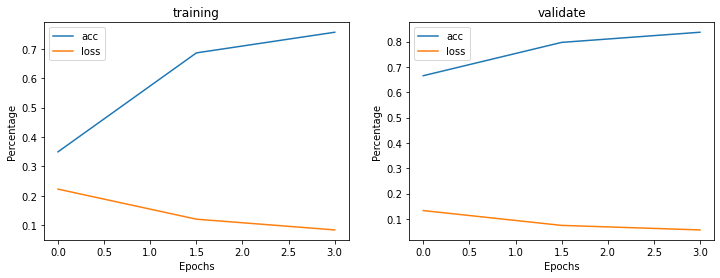

In [13]:
import matplotlib.pyplot as plt
from pprint import pprint

pprint(history, indent=2)

train_acc = history['train_acc']
train_los = history['train_los']
valid_acc = history['valid_acc']
valid_los = history['valid_los']

# for i in range(len(history)):
#     train_acc.append(history[i]['train_acc'])
#     train_los.append(history[i]['train_loss'])
#     valid_acc.append(history[i]['valid_acc'])
#     valid_los.append(history[i]['valid_loss'])
        
def plot_lines(y1, y2, label=None, ax=None):
    epochs = len(y1)
    x = np.linspace(0, epochs, num=epochs)
    ax.plot(x, y1, label="acc")
    ax.plot(x, y2, label="loss")
    # ax.set_title('training v.s. validate')
    ax.set_title(label)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Percentage')
    
    
# 1. Plot in same line, this would work
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1,2,1)
plot_lines(train_acc, train_los, 'training', ax1)
plt.legend()

ax2 = fig.add_subplot(1,2,2)
plot_lines(valid_acc, valid_los, 'validate', ax2)
plt.legend()

plt.show()

In [14]:
currDT = datetime.now()
currStr = currDT.strftime("%Y%m%d-%H%M")

acc_str = int(best_acc * 100)
fname_best_model = 'resnet50_{}_acc{}.pth'.format(currStr, acc_str)

best_model_wts = best_model.state_dict()

OutPath = Params['OutPath']
best_model_out = join(OutPath, fname_best_model)

torch.save(best_model_wts, best_model_out)

In [15]:
# Save parameters to json file

fname = 'Params_{}.json'.format(currStr)
f_abspath = join(OutPath, fname)

json_str = json.dumps(Params, indent=4)
print(json_str)

with open(f_abspath, 'w') as fout:
    fout.write(json_str)

{
    "DataPath": "D:\\GitWork\\dog_breed\\data",
    "OutPath": "D:\\GitWork\\dog_breed\\output",
    "ProcPath": "D:\\GitWork\\dog_breed\\processed",
    "PreTrainPath": "D:\\GitWork\\dog_breed\\pretrained",
    "PreTrainFile": "",
    "TestPath": "D:\\Dataset\\dog-breed-identification\\test",
    "TrainPath": "D:\\Dataset\\dog-breed-identification\\train",
    "CsvLabel": "labels.csv",
    "BatchSize": 16,
    "FracForTrain": 0.8
}


In [16]:
# Save breed dict to json file
fname = 'BreedDict_{}.json'.format(currStr)
f_abspath = join(OutPath, fname)

json_str = json.dumps(dict_bid_fw, indent=4)
print(json_str)

with open(f_abspath, 'w') as fout:
    fout.write(json_str)

{
    "scottish_deerhound": 0,
    "maltese_dog": 1,
    "afghan_hound": 2,
    "entlebucher": 3,
    "bernese_mountain_dog": 4,
    "shih-tzu": 5,
    "great_pyrenees": 6,
    "pomeranian": 7,
    "basenji": 8,
    "samoyed": 9,
    "airedale": 10,
    "tibetan_terrier": 11,
    "leonberg": 12,
    "cairn": 13,
    "beagle": 14,
    "japanese_spaniel": 15,
    "australian_terrier": 16,
    "blenheim_spaniel": 17,
    "miniature_pinscher": 18,
    "irish_wolfhound": 19,
    "lakeland_terrier": 20,
    "saluki": 21,
    "papillon": 22,
    "whippet": 23,
    "siberian_husky": 24,
    "norwegian_elkhound": 25,
    "pug": 26,
    "chow": 27,
    "italian_greyhound": 28,
    "pembroke": 29,
    "ibizan_hound": 30,
    "border_terrier": 31,
    "newfoundland": 32,
    "lhasa": 33,
    "silky_terrier": 34,
    "bedlington_terrier": 35,
    "dandie_dinmont": 36,
    "irish_setter": 37,
    "sealyham_terrier": 38,
    "rhodesian_ridgeback": 39,
    "old_english_sheepdog": 40,
    "collie": 41,